# Code Assignment — Streamlit App for COVID-19 Time Series (Baseline vs. ARIMA)

You will turn your **COVID-19 case count** time series into a **Streamlit web app** that:
- Loads a local CSV (static dataset).
- Preps a daily time series.
- Splits **chronologically (80/20)**.
- Computes a **Naïve Baseline** forecast and an **ARIMA(1,1,1)** forecast.
- Shows **RMSE** for both and plots **Train / Test / Forecasts**.

## Instructor Guidance (Docs + Pseudocode)

**Docs**
- Streamlit: https://docs.streamlit.io/
- `statsmodels` ARIMA: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
- ADF (adfuller): https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
- RMSE (`mean_squared_error`): https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html

**Pseudocode Plan**
1) **Create project folder & venv** → install `streamlit`, `pandas`, `numpy`, `statsmodels`, `scikit-learn`, `matplotlib`.
2) **Put your CSV** (NYC COVID daily counts) in the folder. Expected columns: `date_of_interest`, `case_count`.
3) **app.py skeleton** → `st.title`, side info, etc.
4) **Load CSV** → lowercase columns; parse date; coerce `case_count` to numeric (strip commas); sort by date.
5) **Build daily series** → set index to date; `asfreq("D")`; `interpolate("linear")`.
6) **Chronological split (80/20)** → `train = first 80%`, `test = last 20%`.
7) **Baseline forecast** → repeat last train value; compute **RMSE**.
8) **ARIMA(1,1,1)** → fit on train; forecast `len(test)`; compute **RMSE**.
9) **Plot** → lines for Train, Test, Baseline, ARIMA; display RMSEs.
10) **Run** → `streamlit run app.py`.



## YOU DO

### Step 0 — Create folder, venv, install
Open a terminal in your chosen parent directory and run:

- mkdir covid_streamlit_app && cd covid_streamlit_app
- python -m venv .venv
- source .venv/bin/activate
- pip install streamlit pandas numpy statsmodels scikit-learn matplotlib


## Step 1 — Create a blank app.py and paste the code below.  Fill in the Nones

**This is the answer to what they will have in app.py** Their version will have Nones in it.

- You are free to change the design of the app (this is recommended)

In [6]:
# app.py  — RUN THIS FILE WITH:  streamlit run app.py

import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

st.set_page_config(page_title= "COVID-19 Model", page_icon="🦠", layout="centered")
st.title("COVID-19 ARIMA Model")

st.write("This demo loads a local CSV of **daily case counts**, creates a time series, "
         "splits it chronologically (80/20), then compares a **Naïve Baseline** to **ARIMA(1,1,1)**.")

# === CONFIG ===
DATA_PATH = "/Users/Marcy_Student/Desktop/Marcy-Modules/marcy-git/DA2025_Lectures/Mod6/data/covid_copy.csv"  
DATE_COL  = "date_of_interest"
TARGET_COL = "case_count"

# === LOAD CSV (RUN THIS SECTION WITHOUT CHANGES if your columns match) ===
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    st.error(None)
    st.stop()

#lowercase columns and strip white space
df.columns = df.columns.str.lower().str.strip()
date_col = DATE_COL.lower()
target_col = TARGET_COL.lower()

if date_col not in df.columns or target_col not in df.columns:
    st.error(f"Expected columns `{DATE_COL}` and `{TARGET_COL}` not found. "
             f"Got columns: {df.columns.tolist()}")
    st.stop()

# Parse date and coerce numeric (strip commas like '1,141')
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df[target_col] = pd.to_numeric(df[target_col].astype(str).str.replace(",", "", regex=False), errors="coerce")
df = df.dropna(subset=[date_col, target_col]).sort_values(date_col)

st.caption(f"Data range: {df[date_col].min().date()} → {df[date_col].max().date()}  |  "
           f"Rows: {len(df):,}")

# === BUILD DAILY SERIES ===
#set date index and make sure it is Daily frequency
s = df.set_index(date_col)[target_col].asfreq("D")
s = s.astype("float64").interpolate("linear")  # fill small gaps

# === SPLIT CHRONOLOGICALLY (80/20)  ===
split_idx = int(len(s) * 0.80)
train = s.iloc[:split_idx]
test  = s.iloc[split_idx:]

st.write(f"**Train:** {train.index.min().date()} → {train.index.max().date()}  |  n = {len(train):,}")
st.write(f"**Test :** {test.index.min().date()} → {test.index.max().date()}   |  n = {len(test):,}")

# === BASELINE (Naïve/Shift)===
baseline_pred = pd.Series(train.iloc[-1], index=test.index)
rmse_baseline = np.sqrt(mean_squared_error(test, baseline_pred))

# === ARIMA(1,1,1) (RUN THIS SECTION WITHOUT CHANGES) ===
try:
    arima_model = ARIMA(train, order=(1, 1, 1)).fit()
    arima_pred = arima_model.forecast(steps=len(test))
    rmse_arima = np.sqrt(mean_squared_error(test, arima_pred))
except Exception as e:
    st.error(f"ARIMA failed to fit/forecast: {e}")
    st.stop()

# === METRICS (RUN THIS SECTION WITHOUT CHANGES) ===
col1, col2 = st.columns(2)
with col1:
    st.metric(label="Baseline RMSE", value=f"{rmse_baseline:,.3f}")
with col2:
    st.metric(label="ARIMA(1,1,1) RMSE", value=f"{rmse_arima:,.3f}")

# === PLOTS (RUN THIS SECTION WITHOUT CHANGES) ===
st.subheader("Train / Test / Forecasts")

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(train, label="Train")
ax.plot(test, label="Actual (Test)", color="#ff7f0e")
ax.plot(baseline_pred, label="Baseline Forecast", color="#2ca02c", ls="--")
ax.plot(arima_pred, label="ARIMA(1,1,1) Forecast", color="#1f77b4", ls="--")
ax.set_title("Daily Case Counts: Baseline vs ARIMA")
ax.legend()
st.pyplot(fig)

with st.expander("Peek at head of cleaned data:"):
    st.dataframe(df.head(10))

st.info("**Interpretation tip:** If ARIMA RMSE < Baseline RMSE, the model beats the naive forecast. "
        "If not, revisit stationarity, seasonality (SARIMA), or recent structure changes.")


2025-12-02 12:06:11.987 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 12:06:11.989 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 12:06:11.989 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 12:06:11.990 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 12:06:11.990 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 12:06:11.991 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 12:06:11.992 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-02 12:06:12.010 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

## **She runs!!!**

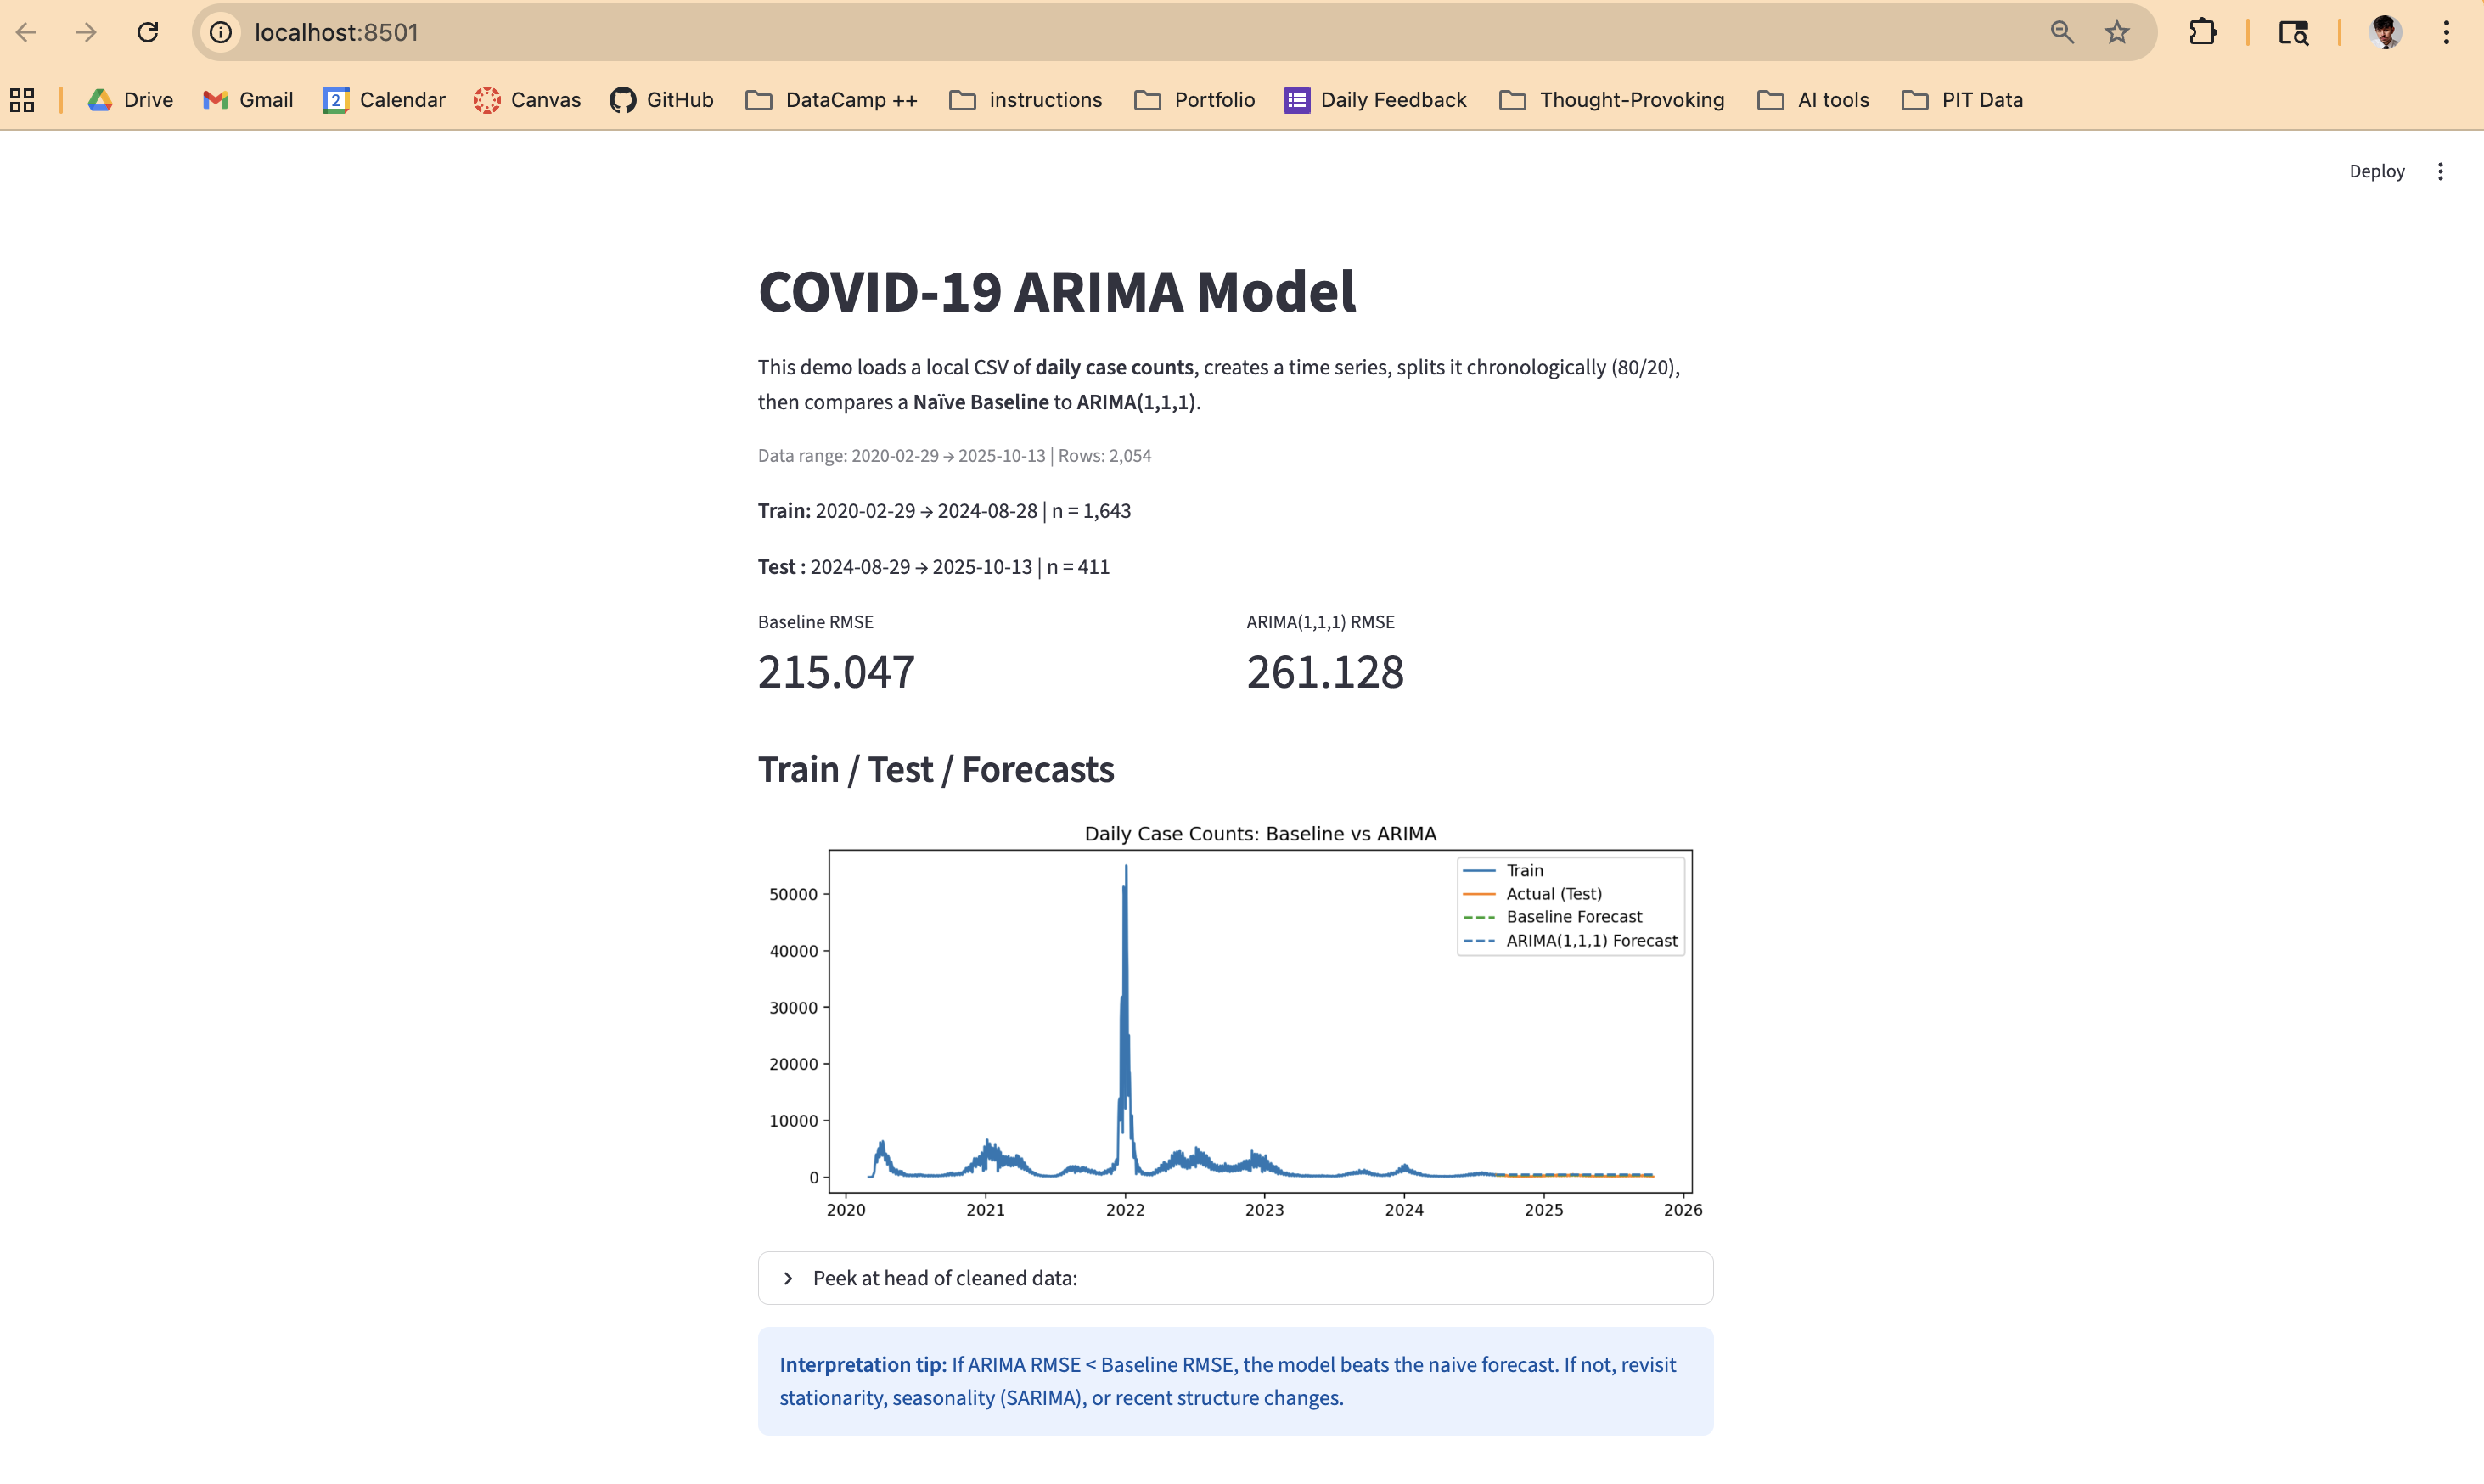